<div class="frontmatter text-center">
<h1>Geospatial Data Science</h1>
<h2>Lecture 9: Spatial networks</h2>
<h3>IT University of Copenhagen, Spring 2022</h3>
<h3>Instructor: Michael Szell</h3>
</div>

# Source
This notebook was adapted from:

* OSMnx examples: https://github.com/gboeing/osmnx-examples/blob/main/notebooks/06-stats-indicators-centrality.ipynb
* Spaghetti: https://pysal.org/spaghetti/notebooks/network-spatial-dependence.html

In [1]:
import geopandas as gpd
import osmnx as ox
import numpy as np
import networkx as nx
import pandas as pd

from haversine import haversine, haversine_vector

import matplotlib.pyplot as plt
from scipy.spatial import Delaunay, delaunay_plot_2d, Voronoi, voronoi_plot_2d

import matplotlib
import spaghetti
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar

%matplotlib inline
ox.__version__

d:\work\miniconda3\envs\OSMNX\lib\site-packages\spaghetti\network.py:39: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


'1.2.2'

# Haversine distance

计算远点之间的距离时始终使用 Haversine 距离：https://github.com/mapado/haversine

In [2]:
copenhagen = (55.67594, 12.56553)  # (lat, lon)
london = (51.509865, -0.118092)
sanfrancisco = (37.773972, -122.431297)
newyork = (40.730610, -73.935242)

In [3]:
haversine(copenhagen, sanfrancisco)

8784.87818320771

In [4]:
haversine_vector(3*[copenhagen], [london, newyork, sanfrancisco])

array([ 954.68540063, 6182.52042412, 8784.87818321])

# 使用OSMnx计算路网指标

首先我们用OSMnx下载Frederiksberg drive网：

In [5]:
place = "Frederiksberg Municipality"
G = ox.graph_from_place(place, network_type="drive")
G_proj = ox.project_graph(G)

## 计算基本街道网络措施（拓扑和几何）

In [6]:
# Calculate Frederiksberg's basic stats, then show the average circuity
stats = ox.basic_stats(G)
stats["circuity_avg"]

1.0274557810151594

要计算基于密度的统计数据，您还必须传递以平方米为单位的网络边界区域（否则 basic_stats() 将在计算中跳过它们）：

In [7]:
# get the street network for a place, and its area in square meters
city = ox.geocode_to_gdf(place)
city_proj = ox.project_gdf(city)
area = city_proj.unary_union.area
area

8705609.47802214

In [8]:
# calculate basic and extended network stats, merge them together, and display
stats = ox.basic_stats(G, area=area)
pd.Series(stats)

n                                                                             804
m                                                                            1918
k_avg                                                                    4.771144
edge_length_total                                                      184398.813
edge_length_avg                                                         96.141196
streets_per_node_avg                                                     2.893035
streets_per_node_counts         {0: 0, 1: 109, 2: 27, 3: 514, 4: 150, 5: 3, 6: 1}
streets_per_node_proportions    {0: 0.0, 1: 0.13557213930348258, 2: 0.03358208...
intersection_count                                                            695
street_length_total                                                    109472.321
street_segment_count                                                         1144
street_length_avg                                                       95.692588
circuity_avg    

街道/交叉路口计数和比例是统计数据字典中的嵌套字典。 要将这些统计数据转换为 pandas 数据框（以相互比较/分析多个网络），只需先解压这些嵌套的字典：

In [9]:
# unpack dicts into individiual keys:values
stats = ox.basic_stats(G, area=area)
for k, count in stats["streets_per_node_counts"].items():
    stats["{}way_int_count".format(k)] = count
for k, proportion in stats["streets_per_node_proportions"].items():
    stats["{}way_int_prop".format(k)] = proportion

# delete the no longer needed dict elements
del stats["streets_per_node_counts"]
del stats["streets_per_node_proportions"]

# load as a pandas dataframe
pd.DataFrame(pd.Series(stats, name="value")).round(3)

,value
n,804.000
m,1918.000
k_avg,4.771
edge_length_total,184398.813
edge_length_avg,96.141
streets_per_node_avg,2.893
intersection_count,695.000
street_length_total,109472.321
street_segment_count,1144.000
street_length_avg,95.693


### 检查介数中心性

In [10]:
# calculate betweenness with a digraph of G (ie, no parallel edges)
bc = nx.betweenness_centrality(ox.get_digraph(G), weight="length")
max_node, max_bc = max(bc.items(), key=lambda x: x[1])
max_node, max_bc

(576734, 0.24822750098601565)

在 Frederiksberg Municipality，介数中心性最高的节点有 25% 的最短路径通过它。 让我们在情节中突出显示它：

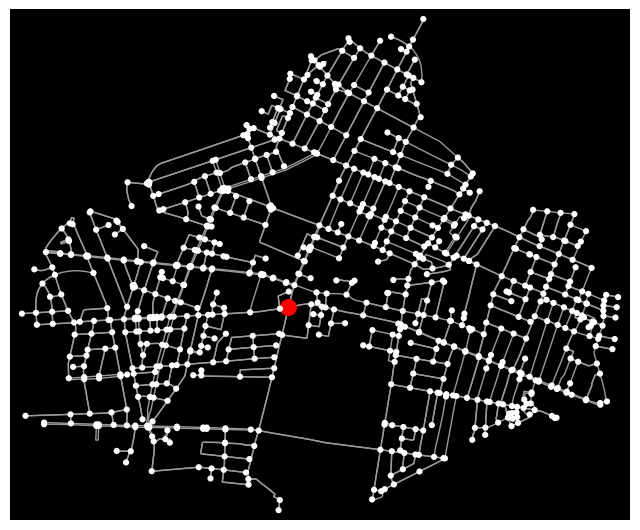

In [11]:
nc = ["r" if node == max_node else "w" for node in G.nodes]
ns = [150 if node == max_node else 20 for node in G.nodes]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2, bgcolor="k")

约 25% 的最短路径穿过以红色突出显示的节点。 让我们看一下图中每个节点的相对介数中心性：

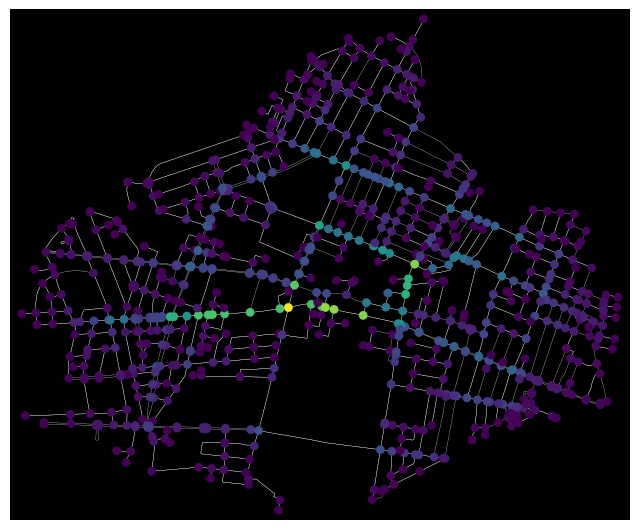

In [12]:
# add the betweenness centrality values as new node attributes, then plot
nx.set_node_attributes(G, bc, "bc")
nc = ox.plot.get_node_colors_by_attr(G, "bc", cmap="viridis")
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=40,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="w",
    bgcolor="k",
)

上面，节点通过中间中心性从低（深紫色）到高（浅黄色）可视化。 颜色空间中的颜色线性映射到属性值。

# Delaunay 三角剖分和 Voronoi 图

让我们展示 Frederiksberg 药店的 Delaunay traingulation 和 Voronoi 图。 特别是，Voronoi 图会告诉我们：离腓特烈斯贝任何地点最近的药房是哪家？

In [13]:
# Let's fetch all pharmacies and project them
tags = {'amenity': ['pharmacy']}
gdf_pharmacies = ox.geometries_from_place(place, tags=tags)
gdf_pharmacies = ox.project_gdf(gdf_pharmacies)
gdf_pharmacies

amenity healthcare                       name  \
element_type osmid                                                        
node         2955867754  pharmacy   pharmacy    Dalgas Boulevard Apotek   
             4886221183  pharmacy   pharmacy           Apoteket Godthåb   
             6579860143  pharmacy   pharmacy         Smallegades Apotek   
             6959994877  pharmacy   pharmacy                   Apoteket   
             7144688116  pharmacy        NaN              Apotek Ørsted   
             8254386587  pharmacy   pharmacy         Apotek Borups Allé   
             8367053969  pharmacy   pharmacy  Frederiksberg Løve Apotek   
             9089831028  pharmacy        NaN       Frederiksberg Apotek   

                                                             opening_hours  \
element_type osmid                                                           
node         2955867754  Mo-Th 09:00-17:30; Fr 09:00-18:00; Sa 09:30-13:30   
             4886221183                  Mo-Fr 09:00-19:00; Sa 09:30-16:00   
             6579860143  08:00-17:30; Sa 09:00-13:30; Su off; Jan 1 off...   
             6959994877                                                NaN   
             7144688116                                  Mo-Su 08:00-20:00   
             8254386587                                        08:00-20:00   
             8367053969  Mo-We 09:30-18:00; Th-Fr 10:00-18:00; Sa 09:30...   
             9089831028                                                NaN   

                        toilets:wheelchair  \
element_type osmid                           
node         2955867754                 no   
             4886221183                NaN   
             6579860143                NaN   
             6959994877                NaN   
             7144688116                NaN   
             8254386587                NaN   
             8367053969                NaN   
             9089831028                NaN   

                                                                   website  \
element_type osmid                                                           
node         2955867754  https://www.apoteket.dk/apoteker/frederiksberg...   
             4886221183                                                NaN   
             6579860143                  https://smallegade.apotekeren.dk/   
             6959994877                                                NaN   
             7144688116                                                NaN   
             8254386587                                                NaN   
             8367053969                                                NaN   
             9089831028                    https://frederiksbergapotek.dk/   

                        wheelchair                        geometry  \
element_type osmid                                                   
node         2955867754        yes  POINT (343488.521 6173461.280)   
             4886221183        NaN  POINT (345229.807 6173831.459)   
             6579860143        yes  POINT (344297.368 6173210.557)   
             6959994877        NaN  POINT (344800.948 6173377.782)   
             7144688116        NaN  POINT (345873.157 6173198.925)   
             8254386587        NaN  POINT (344958.792 6174746.866)   
             8367053969        yes  POINT (345292.193 6173817.514)   
             9089831028        NaN  POINT (345066.585 6172979.164)   

                                              fvst:name fvst:navnelbnr  \
element_type osmid                                                       
node         2955867754                             NaN            NaN   
             4886221183  Frederiksberg Apoteket Godthåb         905864   
             6579860143                             NaN         519499   
             6959994877                             NaN            NaN   
             7144688116                             NaN         909881   
             8254386587          

In [14]:
# Let's extract the coordinates
pharmacies_coords = np.vstack((
    np.array(gdf_pharmacies.geometry.x),
    np.array(gdf_pharmacies.geometry.y)
)).T
pharmacies_coords

array([[ 343488.52137855, 6173461.27954614],
       [ 345229.80663513, 6173831.45918688],
       [ 344297.36826902, 6173210.55650331],
       [ 344800.94761035, 6173377.78158292],
       [ 345873.15652438, 6173198.92544987],
       [ 344958.79160712, 6174746.86613936],
       [ 345292.19260676, 6173817.51436977],
       [ 345066.58541096, 6172979.16380171]])

## Delaunay 三角剖分

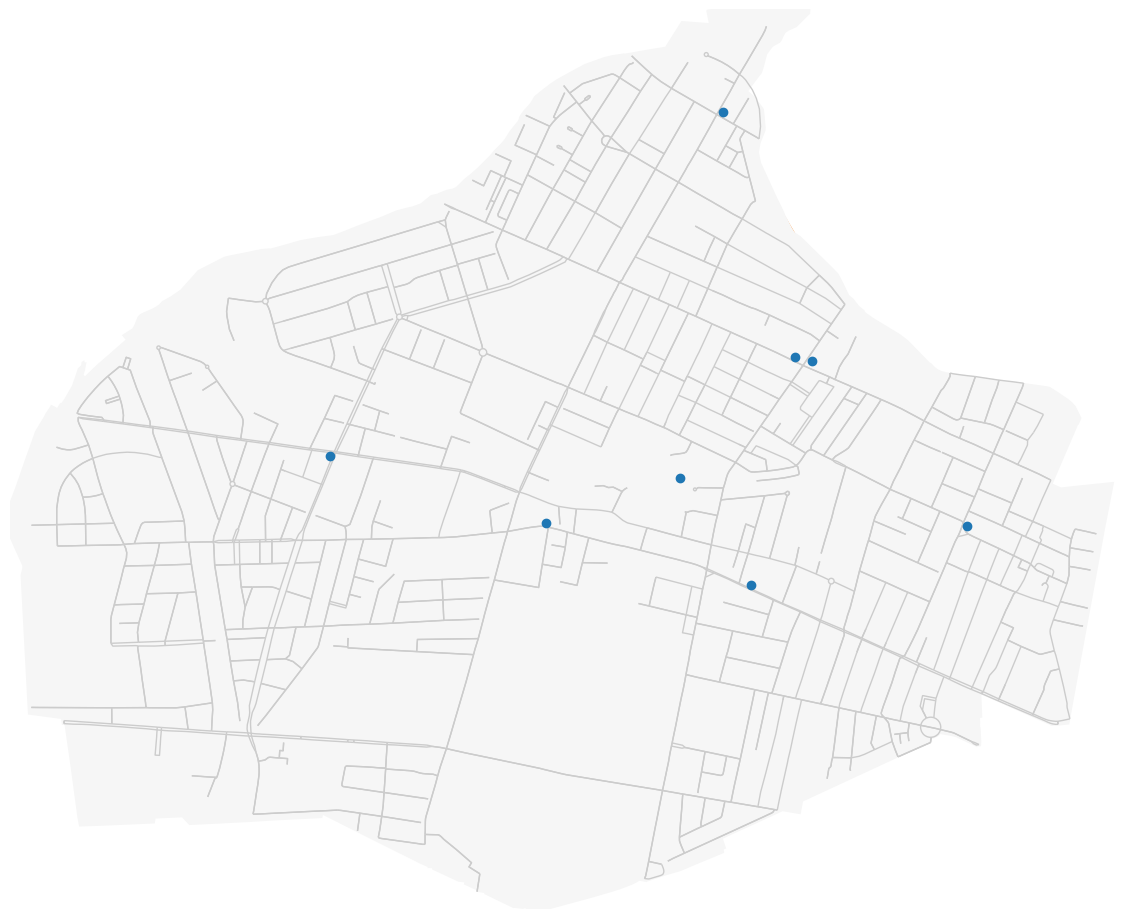

In [15]:
tri = Delaunay(pharmacies_coords)
fig = plt.figure(figsize=(12, 9))
axes = fig.add_axes([0, 0, 1, 1])
delaunay_plot_2d(tri, ax=axes);

# Plot city border
city_proj.plot(fc="#F6F6F6", ec="none", ax=axes);

# Plot street network
ox.plot_graph(G_proj, node_size=0, bgcolor="w", ax=axes, edge_color="#CCCCCC");

## Voronoi diagram

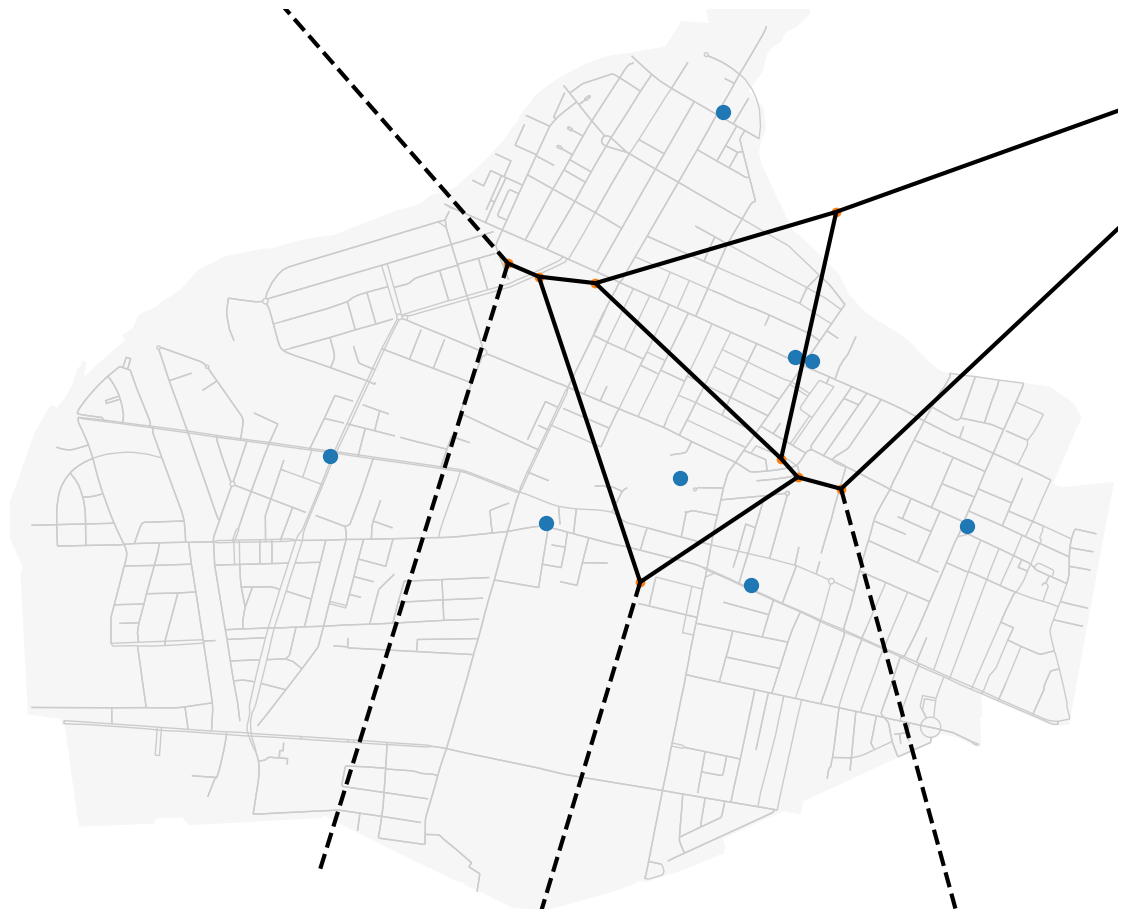

In [16]:
vor = Voronoi(pharmacies_coords)
fig = plt.figure(figsize=(12, 9))
axes = fig.add_axes([0, 0, 1, 1])
voronoi_plot_2d(vor, ax=axes, line_width = 3, point_size=20);

# Plot city border
city_proj.plot(fc="#F6F6F6", ec="none", ax=axes);

# Plot street network
ox.plot_graph(G_proj, node_size=0, bgcolor="w", ax=axes, edge_color="#CCCCCC");

瞧！ 粗黑线向我们展示了离每个药房最近的区域（蓝色）。

# 使用 Spaghetti 的 Ripley's K 网络约束空间聚类

Ripley 的 K 函数采用点模式并考虑最近邻居的所有成对距离，以确定在划定的距离范围内是否存在聚类：https://en.wikipedia.org/wiki/Spatial_descriptive_statistics#Ripley's_K_and_L_functions

然而，将 Ripley 的 K 用于城市便利设施是错误的：无法像乌鸦一样飞到便利设施 - 你不能穿过建筑物 - 但只能通过街道网络。 Spaghetti 包是 PySAL 的一部分——它允许限制对街道网络的空间依赖：https://pysal.org/spaghetti/notebooks/network-spatial-dependence.html 它将点模式分析与空间网络结合起来。 它具有将点捕捉到网络并分析受限于网络的点模式的工具，这对于提出诸如“街道网络上的酒吧/药店*如何聚集？”之类的问题非常有用。

我们想要分析 Frederiksberg 的两个兴趣点 (POI) 数据集：1) 酒吧+餐厅，以及 2) 药房（从上图）。 让我们获取并投影新数据集 pubs+restaurants：

In [17]:
tags = {'amenity': ['pub', 'restaurant']}
gdf_pubs = ox.geometries_from_place(place, tags=tags)
gdf_pubs = ox.project_gdf(gdf_pubs)
gdf_pubs

amenity fvst:navnelbnr                      name  \
element_type osmid                                                              
node         277694702           pub         115321               Cafe Intime   
             277703258           pub         111210                Alléenberg   
             278380921           pub         921122                Cafe Svejk   
             278389273           pub         738934                Promenaden   
             279143638    restaurant         115050              Viet Nam Nam   
...                              ...            ...                       ...   
             9217106974   restaurant        1111573            Bjørnekælderen   
             9280775697   restaurant        1144806                   Circolo   
             9630212016   restaurant         706630  Madklubben frederiksberg   
             10738149718  restaurant         983119       Hanzo Frederiksberg   
             10738149723  restaurant        1239025                     Mamak   

                                                              opening_hours  \
element_type osmid                                                            
node         277694702                                  Mo-Su 16:00 - 02:00   
             277703258                                    Tu-Sa 22:00-05:00   
             278380921                  Su-Mo 12:00-24:00;Tu-Sa 12:00-02:00   
             278389273    Mo-We 11:00-23:00; Th-Sa 11:00-24:00; Su 11:00...   
             279143638                                          16:00-23:00   
...                                                                     ...   
             9217106974                              11:30-23:00; Su-Tu off   
             9280775697   17:30-24:00;Sa 11:30-15:30,17:30-24:00;Su 11:3...   
             9630212016   11:30-15:30,17:00-24:00; Su-Mo 11:30-15:30,17:...   
             10738149718  10:00-17:00; Fr 10:00-20:00; Sa 12:00-20:00; S...   
             10738149723                                                NaN   

                                    phone ref:DK:cvr ref:DK:cvr:pnummer  \
element_type osmid                                                        
node         277694702    +45 38 34 19 58   27979440         1010696328   
             277703258       +45 33254442   25689097         1007991440   
             278380921       +45 38862560   40692932         1024914271   
             278389273                NaN   39126680         1023555944   
             279143638                NaN   54395957         1014630240   
...                                   ...        ...                ...   
             9217106974      +45 47477747   42518824         1027322286   
             9280775697      +45 51302120   42228567         1026929578   
             9630212016      +45 38414170   38554697         1022346209   
             10738149718     +45 38423477   42159743         1026846427   
             10738149723     +45 30116661   42905070         1027825571   

                         toilets  \
element_type osmid                 
node         277694702       yes   
             277703258       yes   
             278380921       NaN   
             278389273       NaN   
             279143638       NaN   
...                          ...   
             9217106974      NaN   
             9280775697      NaN   
             9630212016      NaN   
             10738149718     NaN   
             10738149723     NaN   

                                                                    website  \
element_type osmid                                                            
node         277694702                            http://www.cafeintime.dk/   
             277703258                            http://www.alleenberg.dk/   
             278380921                                                  NaN   
             278389273                                                  NaN   
             279143638      

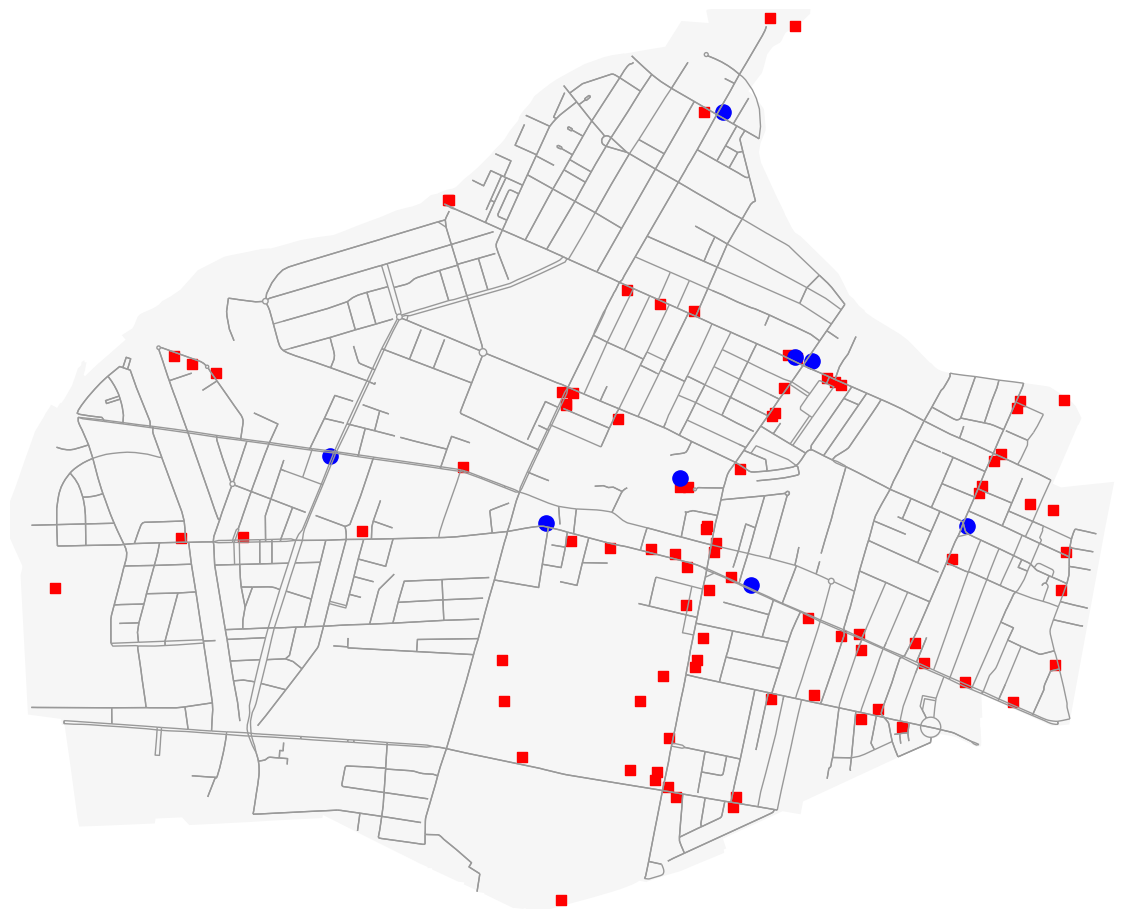

In [18]:
fig = plt.figure(figsize=(12, 9))
axes = fig.add_axes([0, 0, 1, 1])

# Plot city border
city_proj.plot(fc="#F6F6F6", ec="none", ax=axes);

# Plot the two POI datasets
gdf_pubs.plot(ax=axes, color="r", markersize=60, marker="s")
gdf_pharmacies.plot(ax=axes, color="b", markersize=120)

# Plot street network
ox.plot_graph(G_proj, node_size=0, bgcolor="w", ax=axes);

我们首先需要一个辅助函数来进行漂亮的绘图 (adapted from https://pysal.org/spaghetti/notebooks/network-spatial-dependence.html#Results-plotting-helper-function)

In [19]:
def plot_k(k, _arcs, df1, df2, obs, scale=True, wr=[1, 1.2], size=(14, 7)):
    """Plot a Global Auto K-function and spatial context."""
    def function_plot(f, ax):
        """Plot a Global Auto K-function."""
        ax.plot(k.xaxis, k.observed, "b-", linewidth=1.5, label="Observed")
        ax.plot(k.xaxis, k.upperenvelope, "r--", label="Upper")
        ax.plot(k.xaxis, k.lowerenvelope, "k--", label="Lower")
        ax.legend(loc="best", fontsize="x-large")
        title_text = "Global Auto $K$ Function: %s\n" % obs
        title_text += "%s steps, %s permutations," % (k.nsteps, k.permutations)
        title_text += " %s distribution" % k.distribution
        f.suptitle(title_text, fontsize=25, y=1.1)
        ax.set_xlabel("Distance $(r)$", fontsize="x-large")
        ax.set_ylabel("$K(r)$", fontsize="x-large")

    def spatial_plot(ax):
        """Plot spatial context."""
        base = _arcs.plot(ax=ax, color="k", alpha=0.25)
        df1.plot(ax=base, color="g", markersize=30, alpha=0.25)
        df2.plot(ax=base, color="g", marker="x", markersize=100, alpha=0.5)
        carto_elements(base, scale)

    sub_args = {"gridspec_kw":{"width_ratios": wr}, "figsize":size}
    fig, arr = matplotlib.pyplot.subplots(1, 2, **sub_args)
    function_plot(fig, arr[0])
    spatial_plot(arr[1])
    fig.tight_layout()

def carto_elements(b, scale):
    """Add/adjust cartographic elements."""
    if scale:
        kw = {"units":"m", "dimension":"si-length", "fixed_value":1000}
        b.add_artist(ScaleBar(1, **kw))
    b.set(xticklabels=[], xticks=[], yticklabels=[], yticks=[]);

因为 spaghetti 没有集成 OSMnx，所以我们需要使用 shapefile 作为例子。 因此，我们导出图形，以便稍后可以将其作为 spaghetti.Network 导入

In [20]:
ox.io.save_graph_shapefile(G_proj, "Frederiksberg")

d:\work\miniconda3\envs\OSMNX\lib\site-packages\osmnx\io.py:107: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)


现在我们从形状文件构建 spaghetti.Network：

In [21]:
ntw = spaghetti.Network(in_data="Frederiksberg/edges.shp")
vertices_df, arcs_df = spaghetti.element_as_gdf(
    ntw, vertices=ntw.vertex_coords, arcs=ntw.arcs
)

d:\work\miniconda3\envs\OSMNX\lib\site-packages\libpysal\cg\shapes.py:1006: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
d:\work\miniconda3\envs\OSMNX\lib\site-packages\spaghetti\network.py:311: ResourceWarning: unclosed file <_io.BufferedReader name='Frederiksberg/edges.shp'>
  self._extractnetwork()
d:\work\miniconda3\envs\OSMNX\lib\site-packages\spaghetti\network.py:311: ResourceWarning: unclosed file <_io.BufferedReader name='Frederiksberg/edges.shx'>
  self._extractnetwork()


将酒吧和药店捕捉到我们的街道网络，在网络上创建两个点模式：

In [22]:
ntw.snapobservations(gdf_pubs, "pubs", attribute=True)
ntw.snapobservations(gdf_pharmacies, "pharmacies", attribute=True)
ntw.pointpatterns

d:\work\miniconda3\envs\OSMNX\lib\site-packages\libpysal\cg\shapes.py:103: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
d:\work\miniconda3\envs\OSMNX\lib\site-packages\libpysal\cg\shapes.py:1006: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
d:\work\miniconda3\envs\OSMNX\lib\site-packages\libpysal\cg\shapes.py:1923: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
d:\work\miniconda3\envs\OSMNX\lib\site-packages\libpysal\cg\shapes.py:103: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
d:\work\miniconda3\envs\OSMNX\lib\site-packages\libpysal\cg\shapes.py:1006: Future

{'pubs': <spaghetti.network.PointPattern at 0x1d55406bf40>,
 'pharmacies': <spaghetti.network.PointPattern at 0x1d5524cbe20>}

将点图案及其捕捉版本保存为 gdf，以便稍后绘图：

In [23]:
pubs = spaghetti.element_as_gdf(ntw, pp_name="pubs")
pubs_snapped = spaghetti.element_as_gdf(ntw, pp_name="pubs", snapped=True)
pharmacies = spaghetti.element_as_gdf(ntw, pp_name="pharmacies")
pharmacies_snapped = spaghetti.element_as_gdf(ntw, pp_name="pharmacies", snapped=True)

## 酒吧和餐馆聚集

*在网络上*运行 Ripley's K for pubs（这可能需要大约 2 分钟）：

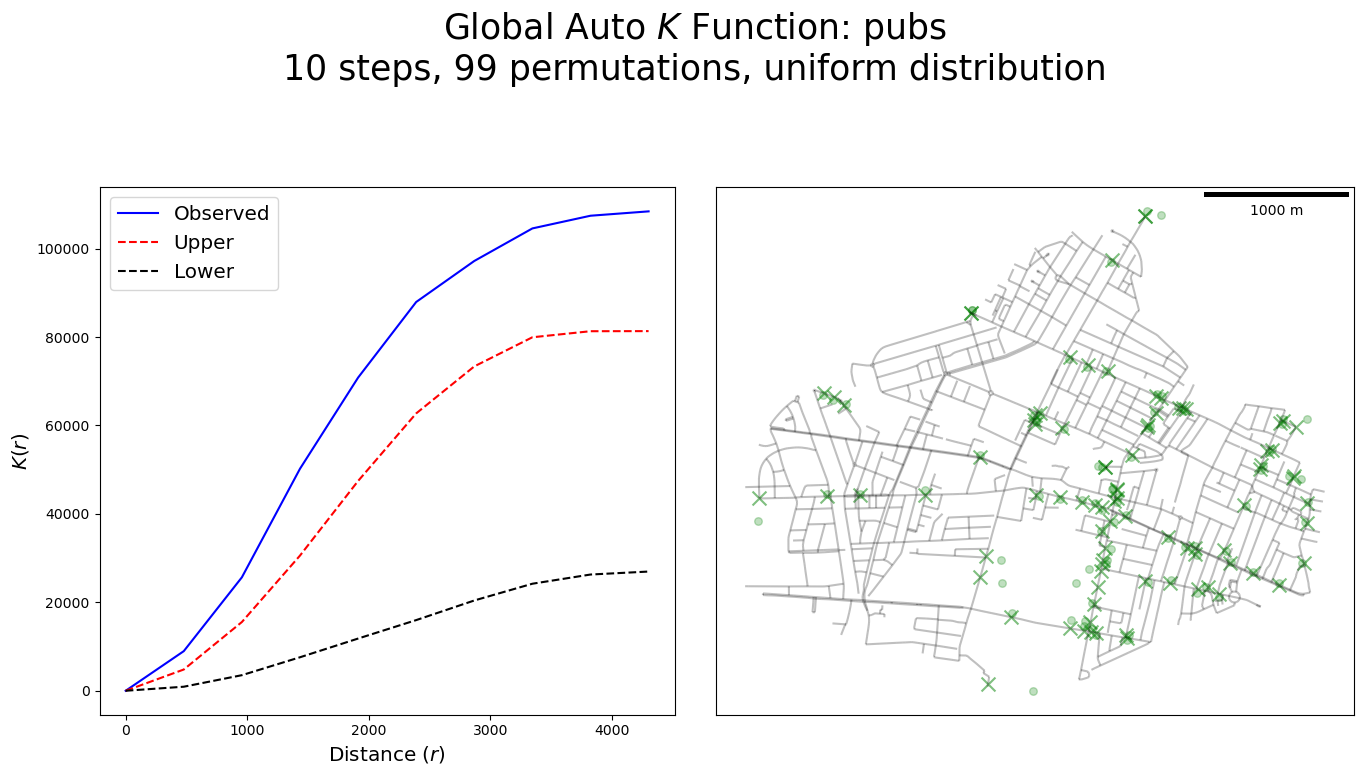

In [24]:
np.random.seed(0)
kres = ntw.GlobalAutoK(
    ntw.pointpatterns["pubs"],
    nsteps=10,
    permutations=99) # Keep permutations low here, otherwise too much time needed for computation
plot_k(kres, arcs_df, pubs, pubs_snapped, "pubs")

### 解释

因为观察到的曲线总是在模拟包络线之上，所以酒吧+餐馆聚集在街道网络上**在所有尺度上**！

它看起来像是集聚经济或商业集群效应的展示，尤其是 Gammel Kongevej 和 Pile Alle/Falkoner Alle：
https://en.wikipedia.org/wiki/Economies_of_agglomeration https://en.wikipedia.org/wiki/Business_cluster#Cluster_effect

## 药店集群

现在让我们在药店运行 Ripley's K。 由于点数少，这要快得多，因此我们可以调高参数：

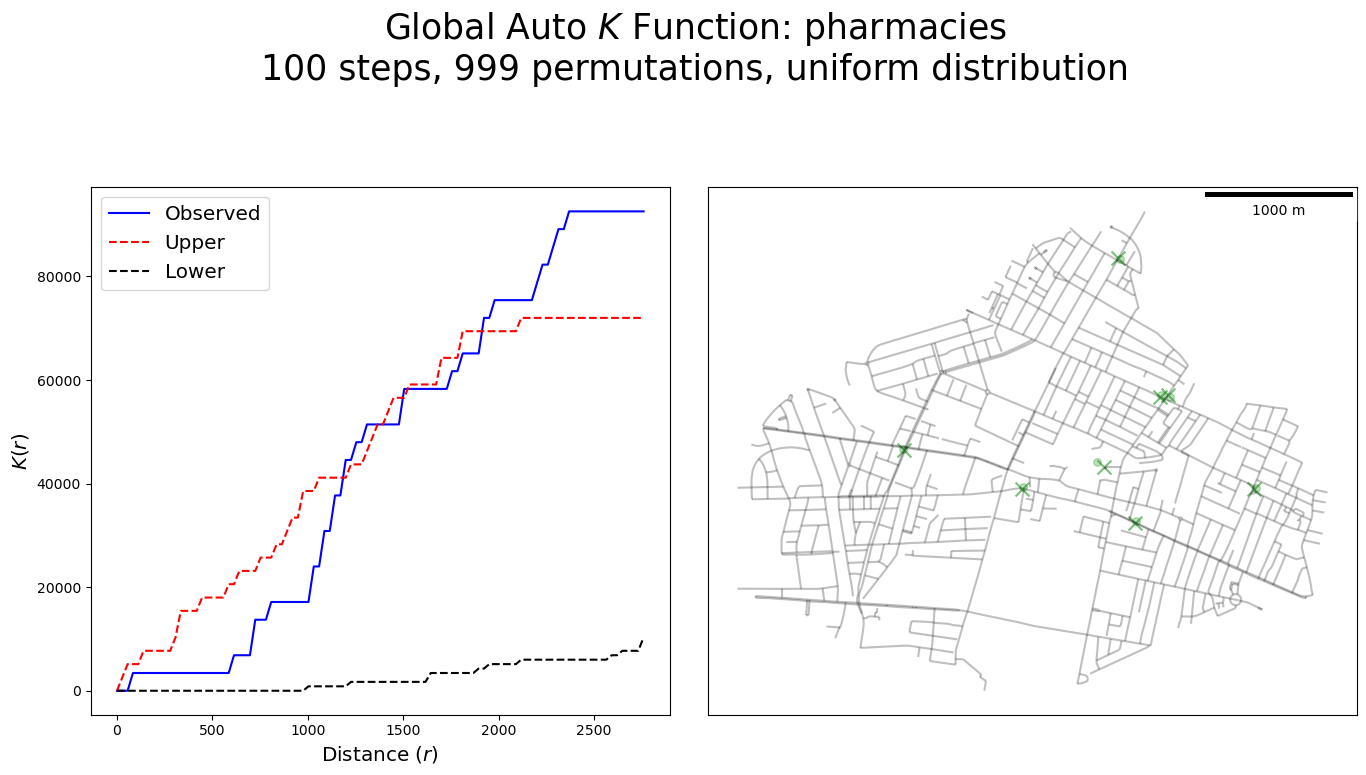

In [25]:
np.random.seed(0)
kres = ntw.GlobalAutoK(
    ntw.pointpatterns["pharmacies"],
    nsteps=100,
    permutations=999)
plot_k(kres, arcs_df, pharmacies, pharmacies_snapped, "pharmacies")

### 解释

药店表现出与酒吧+餐馆不同的聚类行为。 如果不是东北部的那两家药房紧挨着，它们的观察曲线将位于近距离模拟包络线的最低端，表明它们在近距离上相当分散。 也许有最小距离法可以使药店很好地覆盖城市？ 另一方面，对于 2 公里以上的距离，观察到的曲线在包络线之上，这意味着聚类。 在这个规模上，药店集中在东部，腓特烈斯贝的西北部和西南部有相当多的空地。